<img src="https://github.com/Multiomics-Analytics-Group/networks_to_study_microbes/blob/main/figures/cfb.png?raw=1" width="300">


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/networks_to_study_microbes/blob/UdeA2024/notebooks/03_Databases_&_Data_Annotation/06_uniprot_api.ipynb)

# Networks to Study Microbes



# Data Annotation -- Use Case 1

In this notebook, we will use [UniProt's API](https://www.uniprot.org/help/programmatic_access) to get gene/protein information to annotate our experimental data.


As a project dataset, we will use [Xia et al 2022](https://www.nature.com/articles/s41467-022-30513-2): **Proteome allocations change linearly with the specific growth rate of Saccharomyces cerevisiae under glucose limitation**

<div>
<img src="https://github.com/biosustain/data_club/raw/main/figures/xia_et_al_2022.png" width="900"/>
</div>



And specifically the absolute proteome and transcriptome:

<div>
<img src="https://github.com/biosustain/data_club/raw/main/figures/xia_datasets.png" width="500"/>
</div>


In [2]:
import os
import requests, sys
import json
import pandas as pd

In [3]:
transcriptome_df = pd.read_csv("https://raw.githubusercontent.com/Multiomics-Analytics-Group/networks_to_study_microbes/refs/heads/UdeA2024/example_data/Xia_et_al_2022/transcriptomics.tsv", sep='\t', index_col=False)

In [4]:
transcriptome_df.head()

,mRNA,0.027 h-1,0.044 h-1,0.102 h-1,0.152 h-1,0.214 h-1,0.254 h-1,0.284 h-1,0.334 h-1,0.379 h-1
0,R0010W,74.443125,76.433295,48.458353,49.549858,54.371609,54.687635,64.371427,32.918948,41.388778
1,YLR155C,37.844620,36.332161,35.091533,31.096557,29.066724,26.818775,29.592791,23.029033,22.431883
2,YLR159W,7.223876,6.016159,7.014012,5.542861,4.800111,3.934089,4.485135,3.743151,2.596469
3,YHR056C,18.646820,14.038290,14.158659,14.748175,15.365871,13.534869,13.671023,14.309881,13.978857
4,R0030W,209.821451,223.130456,128.572630,122.797999,134.245757,119.268918,116.934733,37.133109,49.136868


In [5]:
transcriptome_df = transcriptome_df.head(n=20)

## UniProt API

We will use two UniProt Proteins API calls:
1) [/proteins](https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/search) to obtain the UniProt accession ids
2) [/proteins/accession](https://www.ebi.ac.uk/proteins/api/doc/#!/proteins/getByAccession) to obtain additional information related to these proteins

## 1) Get Accession ids

In [6]:
def get_accession(gene_name):
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&gene={gene_name}"
    
    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
      r.raise_for_status()
      sys.exit()

    responseBody = r.text
    try:
        json_response = json.loads(responseBody)[0]["accession"]
    except:
        json_response = gene_name

    return json_response

In [7]:
#get_accession(gene_name="R0010W")

## 2) Get additiona information (sequence, organism, sequence_length)

In [8]:
def get_protein_info(accession):
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
      r.raise_for_status()
      sys.exit()
    
    responseBody = r.text
    try:
        json_response = json.loads(responseBody)
    except:
        json_response = {}

    return json_response

def extract_protein_info(accession, response):
    df =pd.DataFrame({"id":response["id"], "taxid":response["organism"]["taxonomy"], 
                      "organism":str(response["organism"]["names"][0]["value"]), 
                      "comments": response["comments"][0]["text"][0]["value"], 
                      "sequence":response["sequence"]["sequence"], 
                      "sequence_length":response["sequence"]["length"], 
                      "sequence_mass":response["sequence"]["mass"]}, index=[accession])
    return(df)

In [9]:
#result = get_protein_info(accession="P03870")

#extract_protein_info(accession="P03870", response=result)


## Incluimos additional information to the Transcriptome dataset

In [10]:
transcriptome_df["Accessions"] = transcriptome_df["mRNA"].apply(lambda x: get_accession(gene_name=x))

In [11]:
transcriptome_df.to_csv("transcriptomics_mapped.tsv", sep='\t', index=False, doublequote=None, header=True)

# Data Annotation -- Use Case 2

In this part, we will use Gene Ontology terms for *S. cerevisiae* downloaded from [GO's website](https://current.geneontology.org/products/pages/downloads.html) to get activity information to annotate our experimental data.

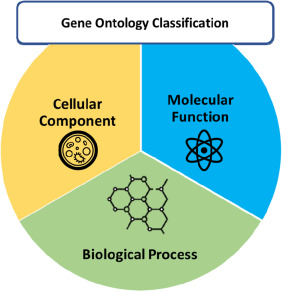

To get information about the Gene Ontology terms, we will make use of [QuickGO API](https://www.ebi.ac.uk/QuickGO/api/index.html)

## Read the *S.  cerevisiae* annotation

In [12]:
go_file = "https://current.geneontology.org/annotations/sgd.gaf.gz"

In [15]:
annotation = pd.read_csv(go_file, sep="\t", compression='gzip', comment='!', header=None)

In [16]:
annotation.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,SGD,S000003381,GPC1,acts_upstream_of_or_within,GO:0090640,PMID:30514764,IGI,SGD:S000005701,P,Glycerophosphocholine acyltransferase (GPCAT),YGR149W|glycerophosphocholine acyltransferase,protein,taxon:559292,20181220,SGD,NaN,UniProtKB:P48236
1,SGD,S000005701,ALE1,acts_upstream_of_or_within,GO:0090640,PMID:30514764,IGI,SGD:S000003381,P,Broad-specificity lysophospholipid acyltransfe...,YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...,protein,taxon:559292,20181220,SGD,NaN,UniProtKB:Q08548
2,SGD,S000003381,GPC1,acts_upstream_of_or_within,GO:0036151,PMID:30514764,IMP,NaN,P,Glycerophosphocholine acyltransferase (GPCAT),YGR149W|glycerophosphocholine acyltransferase,protein,taxon:559292,20181220,SGD,NaN,UniProtKB:P48236
3,SGD,S000004492,RCF1,acts_upstream_of_or_within,GO:0033617,PMID:29746825,IMP,NaN,P,Cytochrome c oxidase subunit,YML030W|AIM31,protein,taxon:559292,20181212,SGD,NaN,UniProtKB:Q03713
4,SGD,S000004977,SIW14,enables,GO:0052845,PMID:26828065,IDA,NaN,F,Inositol phosphatase involved in inositol pyro...,YNL032W|OCA3|putative tyrosine protein phospha...,protein,taxon:559292,20190110,SGD,part_of(GO:0071543),UniProtKB:P53965


## Build a mapping dictionary --> Protein | GO term

In [17]:
# Protein identifiers are in column 11 (format: id|name)
annotation["ids"] = annotation[10].apply(lambda x: x.split("|")[0])
# GO terms are in column 4
annotation = annotation[["ids", 4]]
annotation.columns = ["ids", "go"]

In [18]:
annotation[["ids", "go"]].to_csv("sgd_goa.tsv", sep='\t', header=True, index=False, doublequote=None)

In [19]:
annotation.head()

,ids,go
0,YGR149W,GO:0090640
1,YOR175C,GO:0090640
2,YGR149W,GO:0036151
3,YML030W,GO:0033617
4,YNL032W,GO:0052845


In [20]:
annotation.shape

(120823, 2)

## Filter mapping table with our Protein identifiers in the transcriptomics dataframe

In [21]:
transcriptome_df.head()

,mRNA,0.027 h-1,0.044 h-1,0.102 h-1,0.152 h-1,0.214 h-1,0.254 h-1,0.284 h-1,0.334 h-1,0.379 h-1,Accessions
0,R0010W,74.443125,76.433295,48.458353,49.549858,54.371609,54.687635,64.371427,32.918948,41.388778,P03870
1,YLR155C,37.844620,36.332161,35.091533,31.096557,29.066724,26.818775,29.592791,23.029033,22.431883,P0CZ17
2,YLR159W,7.223876,6.016159,7.014012,5.542861,4.800111,3.934089,4.485135,3.743151,2.596469,P0CE97
3,YHR056C,18.646820,14.038290,14.158659,14.748175,15.365871,13.534869,13.671023,14.309881,13.978857,P38781
4,R0030W,209.821451,223.130456,128.572630,122.797999,134.245757,119.268918,116.934733,37.133109,49.136868,Q06891


In [22]:
annotation_filtered = annotation[annotation["ids"].isin(transcriptome_df["mRNA"])]

In [23]:
annotation_filtered.head()

,ids,go
578,YAL054C,GO:0016208
1556,YHR056C,GO:0006338
1557,YHR056C,GO:0016586
1558,YHR056C,GO:0043565
2542,YAL054C,GO:0019427


In [32]:
annotation_filtered.shape

(372, 2)

## Let's use QuickGO to get the GO term names and definitions

We will make use of the API call [/ontology/go/terms/{ids}](https://www.ebi.ac.uk/QuickGO/api/index.html#!/gene_ontology/findTermsCoreAttrUsingGET_1).

In [30]:
def get_go_details(accession):
    quick_go_url = "https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/ID"
    
    r = requests.get(quick_go_url.replace("ID", accession), headers={ "Accept" : "application/json"})
    
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    
    responseBody = r.text
    try:
        json_response = json.loads(responseBody)
    except:
        json_response = {}

    result = None
    if len(json_response) > 0:
        result = (json_response['results'][0]['name'], json_response['results'][0]['definition']['text'])

    return result

In [36]:
# Requesting only details for the first 20 GO terms
annotation_details = {x: get_go_details(accession=x) for x in annotation_filtered["go"].unique().tolist()[:20]}

In [37]:
annotation_details

{'GO:0016208': ('AMP binding', 'Binding to AMP, adenosine monophosphate.'),
 'GO:0006338': ('chromatin remodeling',
  'A dynamic process of chromatin reorganization resulting in changes to chromatin structure. These changes allow DNA metabolic processes such as transcriptional regulation, DNA recombination, DNA repair, and DNA replication.'),
 'GO:0016586': ('RSC-type complex',
  'A SWI/SNF-type complex that contains a bromodomain containing-protein, such as yeast Rsc1 or Rsc4 or mammalian PB1/BAF180. The RSC complex is generally recruited to RNA polymerase III promoters and is specifically recruited to RNA polymerase II promoters by transcriptional activators and repressors; it is also involved in non-homologous end joining.'),
 'GO:0043565': ('sequence-specific DNA binding',
  'Binding to DNA of a specific nucleotide composition, e.g. GC-rich DNA binding, or with a specific sequence motif or type of DNA e.g. promotor binding or rDNA binding.'),
 'GO:0019427': ('acetyl-CoA biosyntheti

In [41]:
annotation_details = pd.DataFrame(annotation_details, index=["name", "definition"]).transpose()

In [42]:
annotation_details.head()

,name,definition
GO:0016208,AMP binding,"Binding to AMP, adenosine monophosphate."
GO:0006338,chromatin remodeling,A dynamic process of chromatin reorganization ...
GO:0016586,RSC-type complex,A SWI/SNF-type complex that contains a bromodo...
GO:0043565,sequence-specific DNA binding,Binding to DNA of a specific nucleotide compos...
GO:0019427,acetyl-CoA biosynthetic process from acetate,The chemical reactions and pathways resulting ...
